In [14]:
# --- 1. IMPORT CÁC THƯ VIỆN CẦN THIẾT ---
import pandas as pd
import re
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from scipy.sparse import hstack
import matplotlib.pyplot as plt
import seaborn as sns
import os # Thêm thư viện os để làm việc với đường dẫn file

# --- 2. CẤU HÌNH CHO NOTEBOOK ---
# Cấu hình cho biểu đồ đẹp hơn
sns.set_style('whitegrid')
# Lệnh magic để hiển thị biểu đồ ngay trong notebook
%matplotlib inline

# --- 3. CÁC HẰNG SỐ VÀ BIẾN TOÀN CỤC ---
# Đặt một seed cố định để đảm bảo kết quả có thể tái lập
RANDOM_SEED = 42
# Đường dẫn đến thư mục chứa dữ liệu
data_folder = '../data/dataForTrain'
# Danh sách các file CSV sẽ được xử lý
files_to_process = ['CEAS_08.csv', 'Nazario.csv', 'Nigerian_Fraud.csv', 'SpamAssasin.csv']

print("Cell 1: Khai báo và cấu hình hoàn tất.")
print(f"Sẽ xử lý {len(files_to_process)} file từ thư mục: '{data_folder}'")

Cell 1: Khai báo và cấu hình hoàn tất.
Sẽ xử lý 4 file từ thư mục: '../data/dataForTrain'


In [8]:
# Cell 2: Tải và Hợp nhất Dữ liệu Đa trường

all_dfs = [] # List để chứa các DataFrame của từng file
print("Bắt đầu quá trình đọc và hợp nhất 4 file...")

for file_name in files_to_process:
    file_path = os.path.join(data_folder, file_name)
    print(f"\n--- Đang xử lý file: {file_name} ---")
    try:
        # Đọc file CSV, sử dụng encoding='latin1' để tránh lỗi ký tự đặc biệt
        df_temp = pd.read_csv(file_path, encoding='latin1')
        
        # Thêm cột 'source' để biết nguồn gốc của mỗi dòng dữ liệu
        df_temp['source'] = file_name
        
        all_dfs.append(df_temp)
        print(f"-> Đọc thành công. Số dòng: {len(df_temp)}")
        
    except FileNotFoundError:
        print(f"-> LỖI: Không tìm thấy file {file_path}. Bỏ qua.")
    except Exception as e:
        print(f"-> LỖI khi xử lý file {file_path}: {e}. Bỏ qua.")

# Gộp tất cả các DataFrame trong list lại thành một DataFrame tổng
if all_dfs:
    master_df = pd.concat(all_dfs, ignore_index=True)
    
    print("\n--- Gộp dữ liệu hoàn tất ---")
    print(f"Tổng số dòng trước khi làm sạch: {len(master_df)}")
    
    # --- LÀM SẠCH CƠ BẢN ---
    # 1. Chỉ giữ lại các cột cần thiết, đảm bảo một cấu trúc đồng nhất
    # (Loại bỏ các cột không xác định nếu có)
    required_columns = ['sender', 'receiver', 'date', 'subject', 'body', 'label', 'urls', 'source']
    master_df = master_df[required_columns]
    
    # 2. Xử lý các giá trị bị thiếu (chỉ trên các cột quan trọng)
    master_df.dropna(subset=['subject', 'body', 'label'], inplace=True)
    
    # 3. Loại bỏ các dòng bị trùng lặp dựa trên nội dung
    master_df.drop_duplicates(subset=['subject', 'body'], inplace=True, keep='first')
    
    # 4. Chuyển đổi kiểu dữ liệu cho chuẩn
    master_df['label'] = master_df['label'].astype(int)

    print(f"Tổng số dòng sau khi làm sạch cơ bản: {len(master_df)}")
    print("\n--- Thông tin các cột của Master DataFrame ---")
    master_df.info()
else:
    print("\nKhông có dữ liệu để xử lý. Vui lòng kiểm tra lại các file.")

Bắt đầu quá trình đọc và hợp nhất 4 file...

--- Đang xử lý file: CEAS_08.csv ---
-> Đọc thành công. Số dòng: 39154

--- Đang xử lý file: Nazario.csv ---
-> Đọc thành công. Số dòng: 1565

--- Đang xử lý file: Nigerian_Fraud.csv ---
-> Đọc thành công. Số dòng: 3332

--- Đang xử lý file: SpamAssasin.csv ---
-> Đọc thành công. Số dòng: 5809

--- Gộp dữ liệu hoàn tất ---
Tổng số dòng trước khi làm sạch: 49860
Tổng số dòng sau khi làm sạch cơ bản: 49772

--- Thông tin các cột của Master DataFrame ---
<class 'pandas.core.frame.DataFrame'>
Index: 49772 entries, 0 to 49859
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sender    49446 non-null  object
 1   receiver  47706 non-null  object
 2   date      49295 non-null  object
 3   subject   49772 non-null  object
 4   body      49772 non-null  object
 5   label     49772 non-null  int64 
 6   urls      49772 non-null  int64 
 7   source    49772 non-null  object
dtypes: int64(2)

--- Bắt đầu trích xuất và phân tích đặc trưng ---
Trích xuất đặc trưng từ tất cả các trường hoàn tất!

--- Vẽ biểu đồ phân bổ các đặc trưng ---


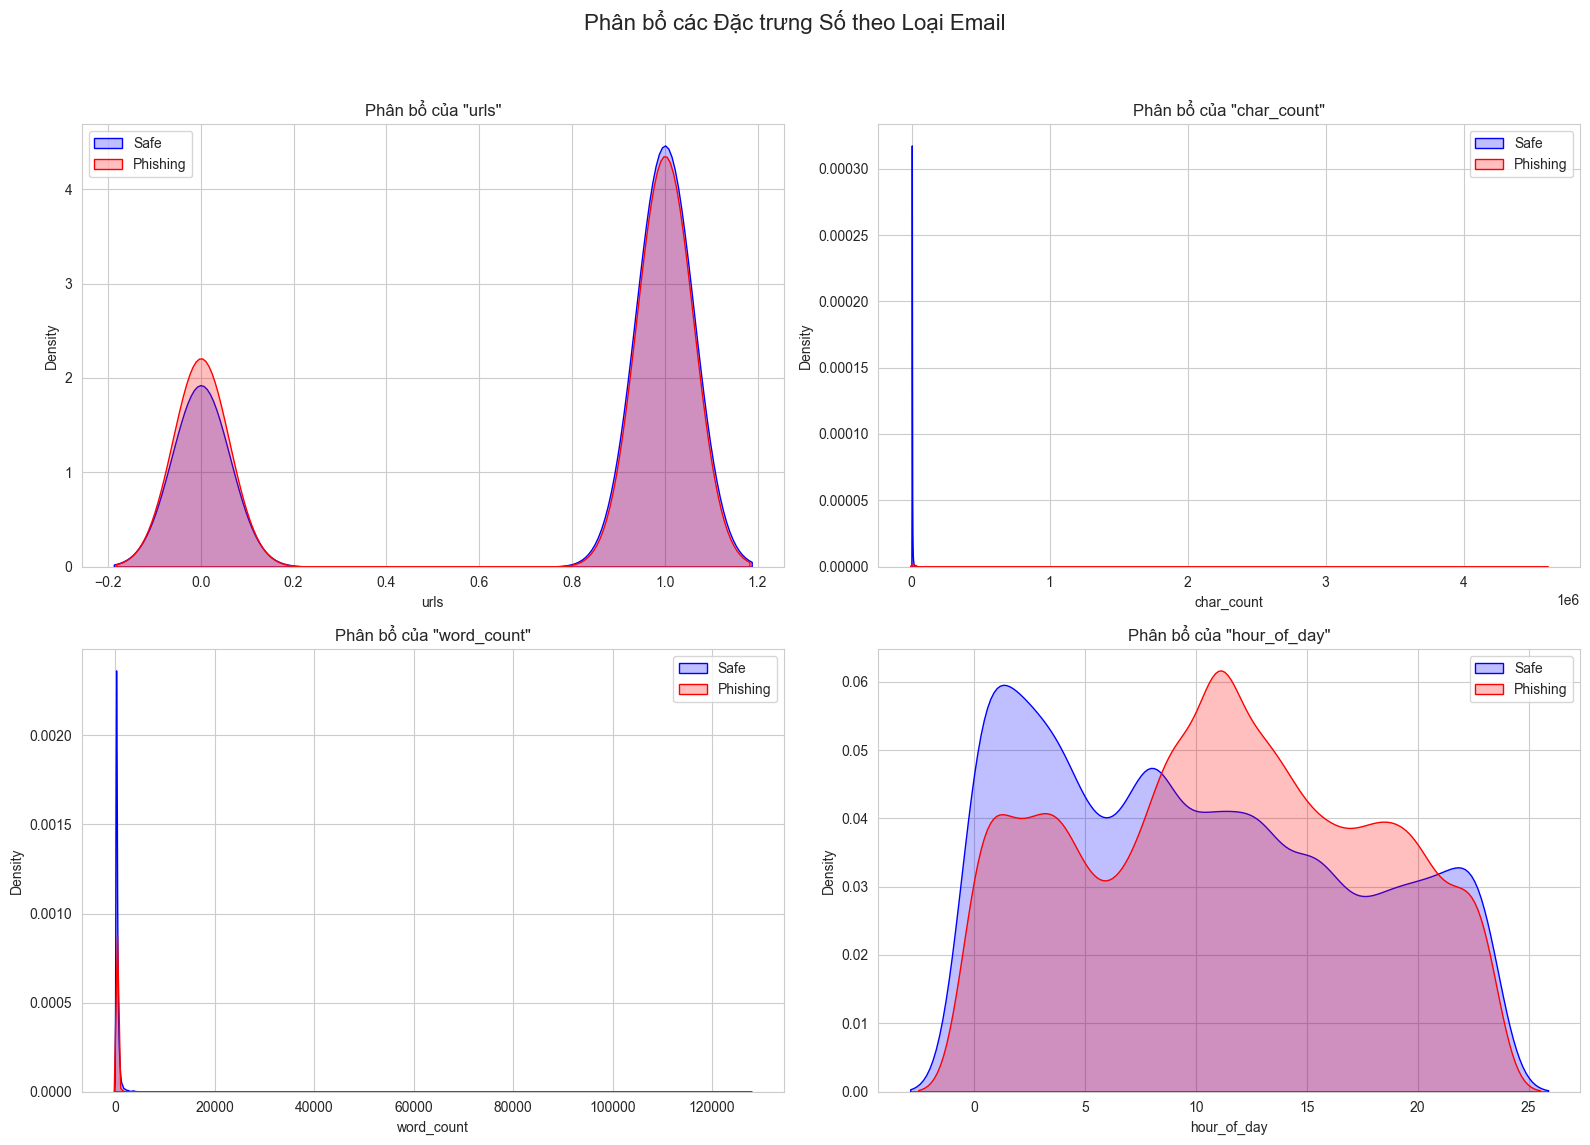

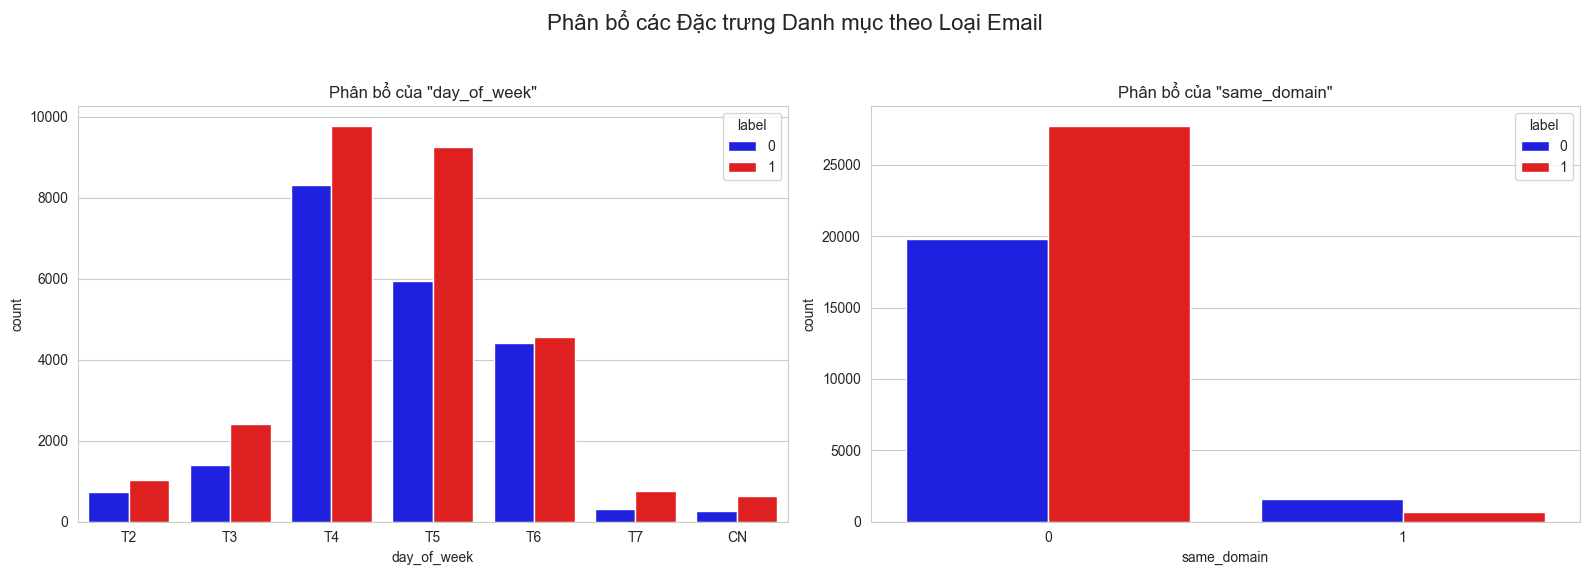

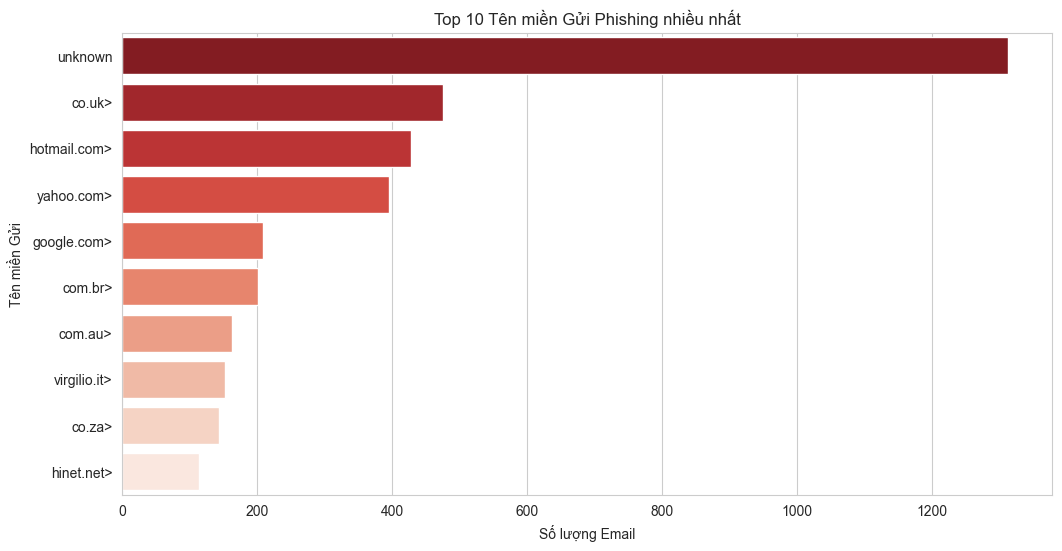

In [16]:
# Cell 3 (Phiên bản Cuối cùng)
import warnings
import re
warnings.filterwarnings('ignore')

if 'master_df' in locals() and not master_df.empty:
    print("--- Bắt đầu trích xuất và phân tích đặc trưng ---")
    
    df_features = master_df.copy()

    # --- 1. TẠO CÁC ĐẶC TRƯNG TỪ CÁC CỘT GỐC ---
    
    # a. Đặc trưng từ 'subject' và 'body'
    df_features['text_combined'] = df_features['subject'].astype(str) + ' ' + df_features['body'].astype(str)
    df_features['char_count'] = df_features['text_combined'].apply(len)
    df_features['word_count'] = df_features['text_combined'].apply(lambda x: len(x.split()))

    # b. Đặc trưng từ 'date'
    def safe_parse_date(date_str):
        if not isinstance(date_str, str): return pd.NaT
        date_str_cleaned = re.sub(r'\s+[A-Z]{2,5}$', '', date_str.strip())
        return pd.to_datetime(date_str_cleaned, utc=True, errors='coerce')
    
    parsed_dates = df_features['date'].apply(safe_parse_date)
    df_features['day_of_week'] = parsed_dates.dt.dayofweek
    df_features['hour_of_day'] = parsed_dates.dt.hour
    
    df_features.fillna({
        'day_of_week': df_features['day_of_week'].median(),
        'hour_of_day': df_features['hour_of_day'].median()
    }, inplace=True)

    # c. Đặc trưng từ 'sender' và 'receiver'
    def get_domain(email_address):
        if not isinstance(email_address, str) or '@' not in email_address:
            return 'unknown'
        domain_parts = email_address.split('@')[-1].split('.')
        return '.'.join(domain_parts[-2:]) if len(domain_parts) >= 2 else domain_parts[-1]

    df_features['sender_domain'] = df_features['sender'].apply(get_domain)
    df_features['receiver_domain'] = df_features['receiver'].apply(get_domain)
    df_features['same_domain'] = (df_features['sender_domain'] == df_features['receiver_domain']).astype(int)
    
    print("Trích xuất đặc trưng từ tất cả các trường hoàn tất!")
    
    # --- 2. PHÂN TÍCH DỮ LIỆU TRỰC QUAN (EDA) TOÀN DIỆN ---
    print("\n--- Vẽ biểu đồ phân bổ các đặc trưng ---")
    
    phishing_df = df_features[df_features['label'] == 1]
    safe_df = df_features[df_features['label'] == 0]
    
    # a. Phân tích các đặc trưng số
    numeric_features_to_analyze = ['urls', 'char_count', 'word_count', 'hour_of_day']
    plt.figure(figsize=(16, 12))
    plt.suptitle('Phân bổ các Đặc trưng Số theo Loại Email', fontsize=16)
    for i, feature in enumerate(numeric_features_to_analyze):
        plt.subplot(2, 2, i + 1)
        sns.kdeplot(safe_df[feature], color='blue', label='Safe', fill=True)
        sns.kdeplot(phishing_df[feature], color='red', label='Phishing', fill=True)
        plt.title(f'Phân bổ của "{feature}"')
        plt.legend()
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    # b. Phân tích các đặc trưng danh mục
    categorical_features_to_analyze = ['day_of_week', 'same_domain']
    plt.figure(figsize=(16, 6))
    plt.suptitle('Phân bổ các Đặc trưng Danh mục theo Loại Email', fontsize=16)
    for i, feature in enumerate(categorical_features_to_analyze):
        plt.subplot(1, 2, i + 1)
        sns.countplot(data=df_features, x=feature, hue='label', palette=['blue', 'red'])
        plt.title(f'Phân bổ của "{feature}"')
        if feature == 'day_of_week':
            plt.xticks(ticks=range(7), labels=['T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'CN'])
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    # c. Phân tích Top 10 sender_domain gây ra phishing nhiều nhất
    plt.figure(figsize=(12, 6))
    top_phishing_domains = df_features[df_features['label'] == 1]['sender_domain'].value_counts().nlargest(10)
    sns.barplot(x=top_phishing_domains.values, y=top_phishing_domains.index, palette='Reds_r')
    plt.title('Top 10 Tên miền Gửi Phishing nhiều nhất')
    plt.xlabel('Số lượng Email')
    plt.ylabel('Tên miền Gửi')
    plt.show()

else:
    print("Master DataFrame chưa được tạo. Vui lòng chạy Cell 2 trước.")

--- Chuẩn bị dữ liệu cho mô hình ---
Vector hóa văn bản bằng TF-IDF...
Lấy các đặc trưng số...
Kết hợp các loại đặc trưng...

Chuẩn bị dữ liệu hoàn tất!
Dữ liệu huấn luyện cuối cùng có dạng (hàng, cột): (39817, 5005)


In [17]:
# Cell 4 (Phiên bản Hoàn thiện)

from sklearn.preprocessing import OneHotEncoder # Thư viện để xử lý cột danh mục

if 'df_features' in locals() and not df_features.empty:
    print("--- Bắt đầu chuẩn bị dữ liệu cho mô hình ---")
    
    # Xác định cột nhãn
    labels = df_features['label']
    
    # Xác định các cột đặc trưng sẽ được sử dụng
    feature_columns_to_use = [
        'text_combined',       # Sẽ được xử lý bằng TF-IDF
        'urls', 'char_count', 'word_count', 'day_of_week', 'hour_of_day', 'same_domain', # Các cột số
        'sender_domain' # Cột danh mục
        # Chúng ta bỏ 'receiver_domain' để giữ cho mô hình đơn giản hơn một chút
    ]
    features_df = df_features[feature_columns_to_use]

    # Chia dữ liệu thành tập huấn luyện (train) và kiểm thử (test)
    X_train, X_test, y_train, y_test = train_test_split(
        features_df, labels, test_size=0.2, random_state=RANDOM_SEED, stratify=labels)
    
    # --- Xử lý các loại đặc trưng khác nhau ---
    
    # a. Vector hóa cột văn bản
    print("1. Vector hóa văn bản bằng TF-IDF...")
    tfidf = TfidfVectorizer(max_features=5000) # Lấy 5000 từ quan trọng nhất
    X_train_text_tfidf = tfidf.fit_transform(X_train['text_combined'])
    X_test_text_tfidf = tfidf.transform(X_test['text_combined'])
    
    # b. Lấy các cột đặc trưng số
    print("2. Lấy các đặc trưng số...")
    numeric_features_cols = ['urls', 'char_count', 'word_count', 'day_of_week', 'hour_of_day', 'same_domain']
    X_train_numeric = X_train[numeric_features_cols].values
    X_test_numeric = X_test[numeric_features_cols].values
    
    # c. Mã hóa cột đặc trưng danh mục ('sender_domain')
    print("3. Mã hóa đặc trưng danh mục ('sender_domain')...")
    # OneHotEncoder sẽ biến mỗi tên miền thành một cột riêng (0 hoặc 1)
    # handle_unknown='ignore' để xử lý các tên miền chỉ có trong tập test mà không có trong tập train
    # max_categories=50 để chỉ lấy 50 tên miền phổ biến nhất, tránh "bùng nổ chiều dữ liệu"
    ohe = OneHotEncoder(handle_unknown='ignore', max_categories=50) 
    X_train_categorical = ohe.fit_transform(X_train[['sender_domain']])
    X_test_categorical = ohe.transform(X_test[['sender_domain']])
    
    # d. Kết hợp tất cả các đặc trưng lại
    print("4. Kết hợp tất cả các loại đặc trưng...")
    X_train_final = hstack([X_train_text_tfidf, X_train_numeric, X_train_categorical]).tocsr()
    X_test_final = hstack([X_test_text_tfidf, X_test_numeric, X_test_categorical]).tocsr()
    
    print(f"\nChuẩn bị dữ liệu hoàn tất!")
    print(f"Dữ liệu huấn luyện cuối cùng có dạng (hàng, cột): {X_train_final.shape}")

else:
    print("DataFrame df_features chưa được tạo. Vui lòng chạy Cell 3 trước.")

--- Bắt đầu chuẩn bị dữ liệu cho mô hình ---
1. Vector hóa văn bản bằng TF-IDF...
2. Lấy các đặc trưng số...
3. Mã hóa đặc trưng danh mục ('sender_domain')...
4. Kết hợp tất cả các loại đặc trưng...

Chuẩn bị dữ liệu hoàn tất!
Dữ liệu huấn luyện cuối cùng có dạng (hàng, cột): (39817, 5056)


--- Bắt đầu huấn luyện mô hình XGBoost ---
--- Huấn luyện hoàn tất ---

--- Báo cáo Đánh giá Mô hình XGBoost (Đa trường) ---
                    precision    recall  f1-score   support

    An toàn (Safe)       0.99      0.99      0.99      4277
Lừa đảo (Phishing)       0.99      0.99      0.99      5678

          accuracy                           0.99      9955
         macro avg       0.99      0.99      0.99      9955
      weighted avg       0.99      0.99      0.99      9955



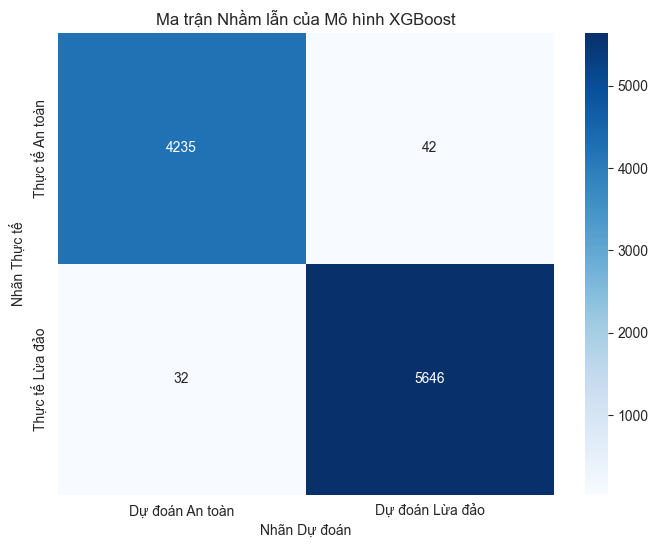

In [18]:
# Cell 5 (Phiên bản Hoàn thiện)

if 'X_train_final' in locals() and 'y_train' in locals():
    print("--- Bắt đầu huấn luyện mô hình XGBoost ---")
    
    # Khởi tạo mô hình XGBoost
    xgb_model = xgb.XGBClassifier(random_state=RANDOM_SEED, use_label_encoder=False, eval_metric='logloss')
    
    # Huấn luyện mô hình
    xgb_model.fit(X_train_final, y_train)
    
    print("--- Huấn luyện hoàn tất ---")

    # --- ĐÁNH GIÁ MÔ HÌNH ---
    # Dự đoán trên tập test
    predictions_xgb = xgb_model.predict(X_test_final)
    
    # In báo cáo đánh giá chi tiết
    print("\n--- Báo cáo Đánh giá Mô hình XGBoost (Đa trường) ---")
    print(classification_report(y_test, predictions_xgb, target_names=['An toàn (Safe)', 'Lừa đảo (Phishing)']))

    # Vẽ ma trận nhầm lẫn
    cm = confusion_matrix(y_test, predictions_xgb)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Dự đoán An toàn', 'Dự đoán Lừa đảo'], 
                yticklabels=['Thực tế An toàn', 'Thực tế Lừa đảo'])
    plt.xlabel('Nhãn Dự đoán')
    plt.ylabel('Nhãn Thực tế')
    plt.title('Ma trận Nhầm lẫn của Mô hình XGBoost')
    plt.show()

else:
    print("Dữ liệu huấn luyện (X_train_final) chưa được tạo. Vui lòng chạy Cell 4 trước.")

--- Phân tích Tầm quan trọng của Đặc trưng ---

--- 20 Đặc trưng Quan trọng nhất theo XGBoost ---
                               feature  importance
3685                                re    0.080138
4950                             wrote    0.052981
4764                           version    0.042113
3222                               org    0.032445
4677                        university    0.021748
2982                            monkey    0.020743
4954                               www    0.020034
1298                              date    0.020032
3350                              perl    0.017378
5024          sender_domain_gmail.com>    0.016829
87                                2008    0.016405
2221                                hi    0.016331
4856                            weight    0.016002
3429                                po    0.014411
1080                           company    0.012330
2712                              list    0.011917
4979                              y

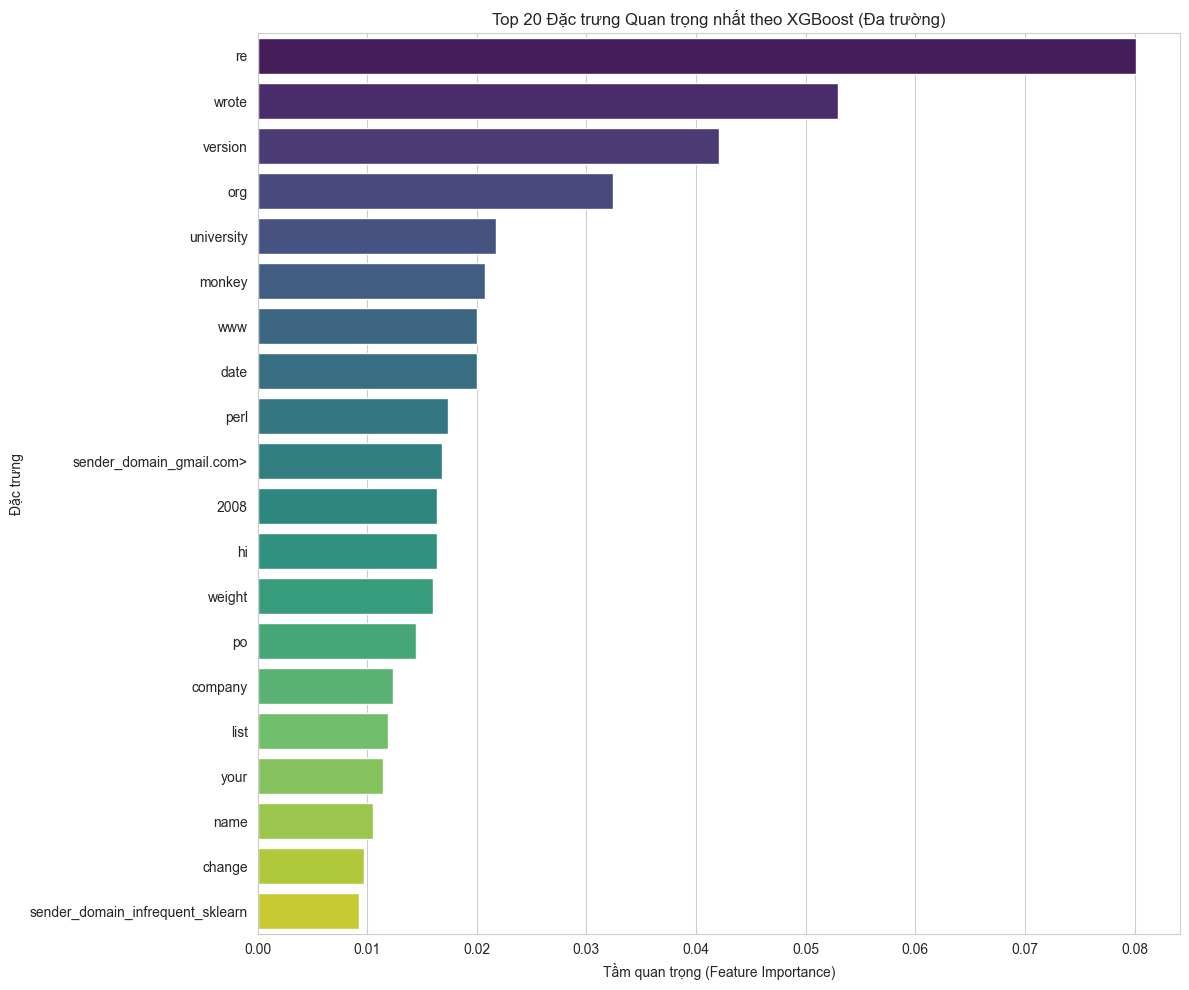


--- TOÀN BỘ QUY TRÌNH PHÂN TÍCH XGBOOST ĐÃ HOÀN TẤT ---


In [19]:
# Cell 6 (Phiên bản Hoàn thiện)

if 'xgb_model' in locals():
    print("--- Phân tích Tầm quan trọng của Đặc trưng ---")

    # --- LẤY LẠI TÊN CỦA TẤT CẢ CÁC ĐẶC TRƯNG ---
    feature_names_tfidf = tfidf.get_feature_names_out()
    feature_names_numeric = numeric_features_cols 
    feature_names_categorical = ohe.get_feature_names_out()
    
    # Nối tất cả các tên đặc trưng lại theo đúng thứ tự
    all_feature_names = np.concatenate([
        feature_names_tfidf, 
        feature_names_numeric, 
        feature_names_categorical
    ])
    
    # --- TẠO DATAFRAME VÀ TRỰC QUAN HÓA ---
    feature_importance_df = pd.DataFrame({
        'feature': all_feature_names,
        'importance': xgb_model.feature_importances_
    }).sort_values('importance', ascending=False)

    print("\n--- 20 Đặc trưng Quan trọng nhất theo XGBoost ---")
    print(feature_importance_df.head(20))

    # Vẽ biểu đồ
    plt.figure(figsize=(12, 10))
    sns.barplot(x='importance', y='feature', data=feature_importance_df.head(20), palette='viridis')
    plt.title('Top 20 Đặc trưng Quan trọng nhất theo XGBoost (Đa trường)')
    plt.xlabel('Tầm quan trọng (Feature Importance)')
    plt.ylabel('Đặc trưng')
    plt.tight_layout()
    plt.show()

else:
    print("Mô hình XGBoost chưa được huấn luyện. Vui lòng chạy Cell 5 trước.")

print("\n--- TOÀN BỘ QUY TRÌNH PHÂN TÍCH XGBOOST ĐÃ HOÀN TẤT ---")

In [20]:
# Cell 7: Lưu trữ Mô hình và các thành phần cần thiết

import joblib
import os

# --- TẠO THƯ MỤC ĐỂ LƯU MODEL ---
model_folder = '../models'
os.makedirs(model_folder, exist_ok=True) # Tạo thư mục nếu chưa có

# --- LƯU CÁC THÀNH PHẦN ---

# 1. Lưu mô hình XGBoost đã được huấn luyện
model_path = os.path.join(model_folder, 'xgboost_model.pkl')
joblib.dump(xgb_model, model_path)
print(f"Đã lưu mô hình XGBoost vào: {model_path}")

# 2. Lưu lại "bộ từ điển" TF-IDF
# QUAN TRỌNG: Chúng ta cần chính xác bộ từ điển này để biến đổi email mới
tfidf_path = os.path.join(model_folder, 'tfidf_vectorizer.pkl')
joblib.dump(tfidf, tfidf_path)
print(f"Đã lưu TF-IDF Vectorizer vào: {tfidf_path}")

# 3. Lưu lại danh sách các cột đặc trưng số
# Chúng ta cần biết thứ tự các cột này để xử lý email mới
numeric_cols_path = os.path.join(model_folder, 'numeric_features_cols.pkl')
joblib.dump(numeric_features_cols, numeric_cols_path)
print(f"Đã lưu danh sách các cột số vào: {numeric_cols_path}")

# 4. Lưu lại bộ mã hóa OneHotEncoder
# Cần để xử lý cột 'sender_domain' của email mới
ohe_path = os.path.join(model_folder, 'one_hot_encoder.pkl')
joblib.dump(ohe, ohe_path)
print(f"Đã lưu OneHotEncoder vào: {ohe_path}")

Đã lưu mô hình XGBoost vào: ../models\xgboost_model.pkl
Đã lưu TF-IDF Vectorizer vào: ../models\tfidf_vectorizer.pkl
Đã lưu danh sách các cột số vào: ../models\numeric_features_cols.pkl
Đã lưu OneHotEncoder vào: ../models\one_hot_encoder.pkl
